# Sidekick - Visualization
More advanced visualization.

In [139]:
%matplotlib inline
from __future__ import print_function
import os
import sys
sys.path.insert(0, os.path.abspath('../utils/')) # Add sibling to Python path
sys.path.insert(0, os.path.abspath('../src/')) # Add sibling to Python path
sys.stdout.flush() # Print output on the fly in Notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16,8)
#matplotlib.rcParams['figure.figsize'] = (20,20)
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['legend.fontsize'] = 16
from IPython.display import display
import numpy as np
import pickle as cp
import matplotlib.pyplot as plt
from dataset import Sidekick
from sklearn import linear_model

def extract_jumps_and_times(project):
    jumps = np.diff(project.money)
    # -1 as first index to count the first jump (between 0 and the first pledge)
    times = np.diff([-1] + [i for i, j in enumerate(jumps) if j != 0])
    jumps = filter(lambda j: j != 0, jumps)
    return jumps, times

def show_histogram(y, x_label, y_label, title="", x_scale='linear', y_scale='linear', bins=100, density=False, 
                   width=0.7, color='b', file_name=None, plot=True):
    hist, bins = np.histogram(y, bins=bins, density=density)
    w = width * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.bar(center, hist, align='center', width=w, color=color)
    # Make counts of 1 visible in log scale
    ax.set_ylim(0.9, ax.get_ylim()[1] + 0.1 * ax.get_ylim()[1])
    ax.set_yscale(y_scale)
    ax.set_xscale(x_scale)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)
    if file_name:
        plt.savefig(file_name)
    if plot:
        plt.show()
    return hist, bins
    
def generate_jumps_times(iterable_collection_of_project):
    jumps = []
    times = []
    for project in iterable_collection_of_project:
        j, t = extract_jumps_and_times(project)
        jumps.extend(j)
        times.extend(t)
    return jumps, times

def subsample(t, granularity):
    if granularity > 1.0 or granularity <= 0:
        raise ValueError("granularity must be in ]0, 1]")
    t0 = 1
    n_samples = int(np.ceil(granularity * t))
    if n_samples == 1:
        return [t]
    else:
        return np.linspace(t0, t, n_samples, dtype=int)

In [189]:
sk = Sidekick()
sk.load()
successful = sk.successful()
failed = sk.failed()
projects_train, projects_test = sk.split(threshold=0.7)

Loading data set...
Data loaded.


In [ ]:
durations = [p.deadline - p.start_date for p in successful]
print(np.median(durations), np.mean(durations))
#_ = show_histogram(durations, "Duration", "Counts")

## Projects Trajectories

In [ ]:
#N = 15000
t = np.linspace(0, 1, 1000)
outlier = 2
projects = [p for p in sk if p.money[-1] <= outlier]
#projects = projects[:N]
max_goal = np.max([p.goal for p in projects])
for i, p in enumerate(projects):
    lw = 10 * p.goal / max_goal
    lw = lw if lw > 0.5 else 0.5
    #plt.plot(t, p.money, 'k', alpha=0.2, lw=lw)
    if p.successful:
        plt.plot(t, p.money, 'g', alpha=0.2, lw=lw)
    else:
        plt.plot(t, p.money, 'r', alpha=0.2, lw=lw)
#plt.yscale('log')
#plt.xscale('log')
plt.plot((0, 1), (1, 1), 'k-', lw=4)
plt.ylim([0, outlier])
plt.ylabel("Relative money")
plt.xlabel("Relative time")
plt.title("Project trajectories")
plt.savefig("trajectories_all_projects.pdf")
plt.show()

In [ ]:
#N = 15000
t = np.linspace(0, 1, 1000)
outlier = 2
projects = [p for p in sk if p.money[-1] <= outlier and p.successful]
#projects = projects[:N]
for i, p in enumerate(projects):
    lw = p.goal / 10000
    if lw > 10:
        lw = 10
    elif lw < 0.5:
        lw = 0.5
    plt.plot(t, p.money, 'k', alpha=0.1, lw=lw)
#plt.yscale('log')
#plt.xscale('log')
plt.plot((0, 1), (1, 1), 'k-', lw=4)
plt.ylim([0, outlier])
plt.ylabel("Relative money")
plt.xlabel("Relative time")
plt.title("Successful project trajectories (width represents the goal)")
plt.savefig("trajectories_successful_projects.pdf")
plt.show()

In [ ]:
#N = 15000
t = np.linspace(0, 1, 1000)
outlier = 2
projects = [p for p in sk if p.money[-1] <= outlier and not p.successful]
#projects = projects[:N]
for i, p in enumerate(projects):
    lw = p.goal / 10000
    if lw > 10:
        lw = 10
    elif lw < 0.5:
        lw = 0.5
    plt.plot(t, p.money, 'k', alpha=0.1, lw=lw)
    #if p.successful:
    #    plt.plot(t, p.money, 'g', alpha=0.5, lw=lw)
    #else:
    #    plt.plot(t, p.money, 'r', alpha=0.5, lw=lw)
#plt.yscale('log')
#plt.xscale('log')
plt.plot((0, 1), (1, 1), 'k-', lw=4)
plt.ylim([0, 1])
plt.ylabel("Relative money")
plt.xlabel("Relative time")
plt.title("Failed project trajectories (width represents the goal)")
plt.savefig("trajectories_failed_projects.pdf")
plt.show()

Linear regression coefficients: [ 1203.57735135] [[ 83.84610861]]


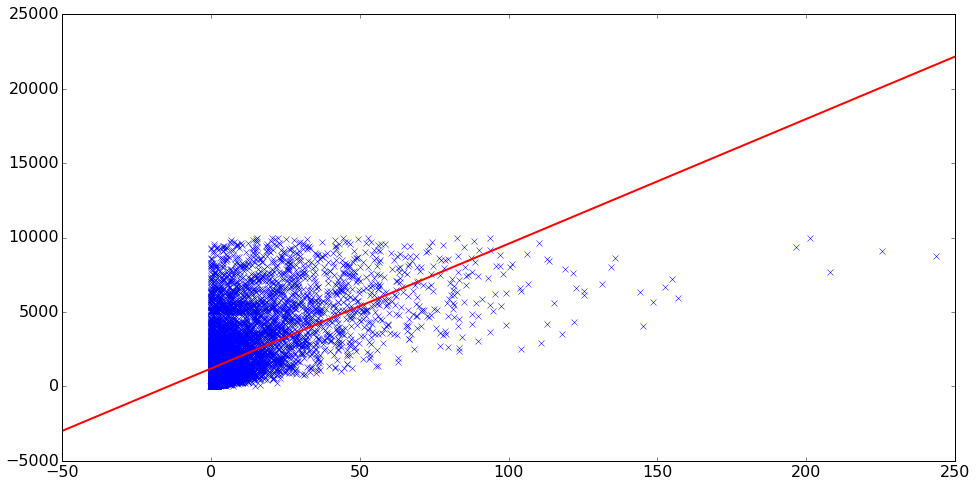

In [243]:
t = 25
granularity = 1
samples = subsample(t, granularity)
n_samples = 1

T = 999
outlier_threshold = 10000
normalized = False

stat = np.mean

if normalized:
    projects_train_filtered = [p for p in projects_train if np.all((p.money[T] - outlier_threshold) <= 0) and np.all((p.money[samples] - outlier_threshold) <= 0)]
    projects_test_filtered = [p for p in projects_test if np.all((p.money[T] - outlier_threshold) <= 0) and np.all((p.money[samples] - outlier_threshold) <= 0)]

    X_train = np.ndarray(shape=(len(projects_train_filtered), n_samples), buffer=np.array([stat(np.diff(p.money[samples])) for p in projects_train_filtered]), dtype=float)
    y_train = np.expand_dims(np.array([p.money[T] for p in projects_train_filtered]), axis=1)
    X_test = np.ndarray(shape=(len(projects_test_filtered), n_samples), buffer=np.array([stat(np.diff(p.money[samples])) for p in projects_test_filtered]), dtype=float)
    y_test = np.expand_dims(np.array([p.money[T] for p in projects_test_filtered]), axis=1)
else:
    projects_train_filtered = [p for p in projects_train if np.all((p.money[T] * p.goal - outlier_threshold) <= 0) and np.all((p.money[samples]* p.goal - outlier_threshold) <= 0)]
    projects_test_filtered = [p for p in projects_test if np.all((p.money[T] * p.goal - outlier_threshold) <= 0) and np.all((p.money[samples]* p.goal - outlier_threshold) <= 0)]

    X_train = np.ndarray(shape=(len(projects_train_filtered), n_samples), buffer=np.array([stat(np.diff(p.money[samples] * p.goal)) for p in projects_train_filtered]), dtype=float)
    y_train = np.expand_dims(np.array([p.money[T] * p.goal for p in projects_train_filtered]), axis=1)
    X_test = np.ndarray(shape=(len(projects_test_filtered), n_samples), buffer=np.array([stat(np.diff(p.money[samples] * p.goal)) for p in projects_test_filtered]), dtype=float)
    y_test = np.expand_dims(np.array([p.money[T] * p.goal for p in projects_test_filtered]), axis=1)

# Create linear regression object
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
print('Linear regression coefficients:', regr.intercept_, regr.coef_)

plt.plot(X_train, y_train, 'x')
x = np.linspace(plt.xlim()[0], plt.xlim()[1], 1000)
y_pred = x * regr.coef_ + regr.intercept_
plt.plot(x, y_pred[0], 'r-', lw=2)
plt.show()

In [244]:
se_successful = []
se_failed = []
se_total = []
accuracy = 0
for i, x_test in enumerate(X_test):
    p = projects_test_filtered[i]
    goal = float(p.goal)
    x_test = np.expand_dims(x_test, axis=0)
    y_pred = x_test * regr.coef_ + regr.intercept_
    y_pred = y_pred[0]
    y_actual = y_test[i][0]
    se = (y_pred - y_actual)**2
    se_total.append(se)
    if y_test[i] >= 1.0:  # Project is successful
        se_successful.append(se)
    else:  # project is failed
        se_failed.append(se)
    if normalized:
        if (y_pred >= 1 and y_actual >= 1) or (y_pred < 1 and y_actual < 1):
            accuracy += 1
    else:
        if (y_pred / goal >= 1 and y_actual / goal >= 1) or (y_pred / goal < 1 and y_actual / goal < 1):
            accuracy += 1
    #else:
    #    print("Error:", i)

rmse_successful = np.sqrt(np.mean(se_successful))
rmse_failed = np.sqrt(np.mean(se_failed))
rmse_total = np.sqrt(np.mean(se_total))
accuracy /= float(len(y_test))

print("Accuracy: ", accuracy)
print("RMSE: ", rmse_total)
print("RMSE successful: ", rmse_successful)
print("RMSE failed: ", rmse_failed)



Accuracy:  0.7290836653386454
RMSE:  1946.39780032
RMSE successful:  1997.06291028
RMSE failed:  1203.77837189


Linear regression: f(x) = 1425.58x + 37.65


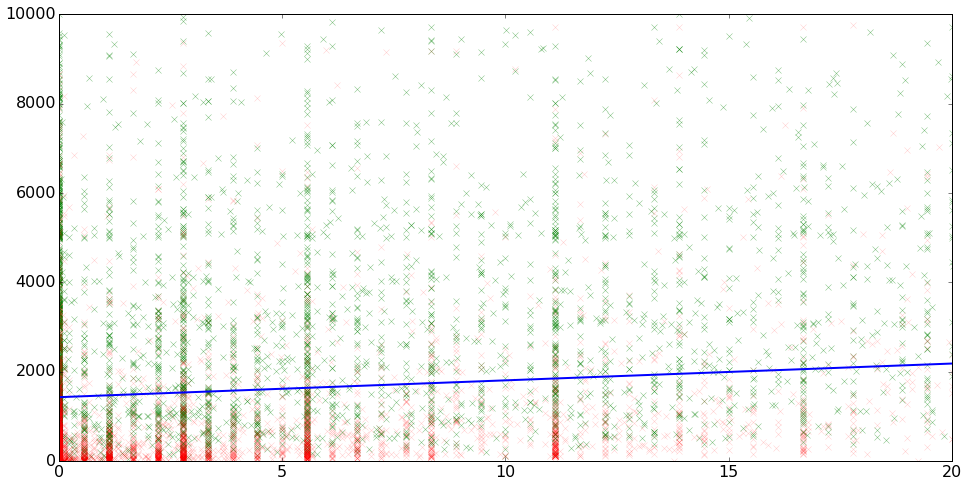

In [224]:
t = 10
granularity = 1
samples = subsample(t, granularity)
n_samples = len(samples)

T = 999
outlier_threshold = 10000
normalized = True

projects_filtered = [p for p in sk if np.all((p.money[T] * p.goal - outlier_threshold) <= 0) and np.all((p.money[samples]* p.goal - outlier_threshold) <= 0)]
X = np.ndarray(shape=(len(projects_filtered), 1), buffer=np.array([np.mean(np.diff(p.money[samples] * p.goal)) for p in projects_filtered]), dtype=float)
y = np.expand_dims(np.array([p.money[T] * p.goal for p in projects_filtered]), axis=1)

plt.plot([stat(np.diff(p.money[samples] * p.goal)) for p in projects_filtered if p.successful], [p.money[T] * p.goal for p in projects_filtered if p.successful], 'gx', alpha=0.5)
plt.plot([stat(np.diff(p.money[samples] * p.goal)) for p in projects_filtered if not p.successful], [p.money[T] * p.goal for p in projects_filtered if not p.successful], 'rx',  alpha=0.2)


# Create linear regression object
regr = linear_model.LinearRegression()
regr.fit(X, y)
print('Linear regression: f(x) = %0.2fx + %0.2f' % (regr.intercept_, regr.coef_))

x = np.linspace(plt.xlim()[0], plt.xlim()[1], 1000)
y_pred = x * regr.coef_ + regr.intercept_
plt.plot(x, y_pred[0], 'b-', lw=2)
plt.xlim([0, 20])
plt.ylim([0, outlier_threshold])
plt.show()


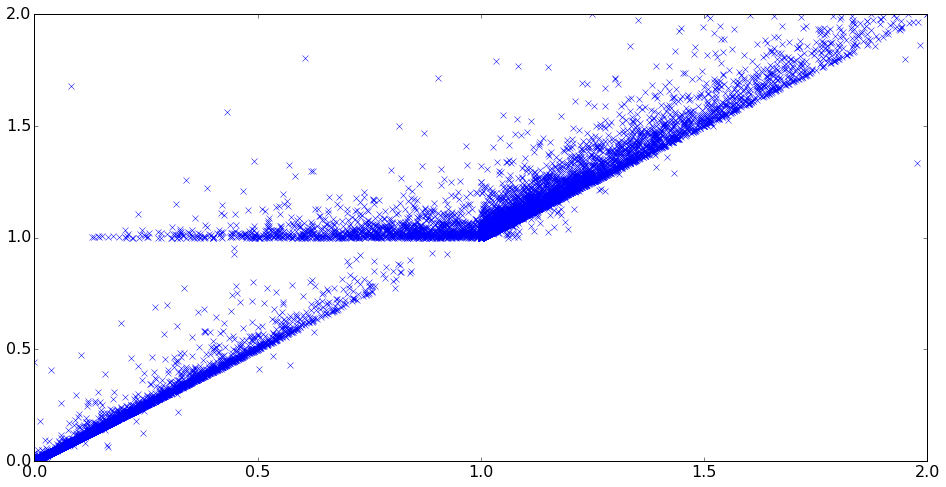

In [171]:
t = 975
granularity = 0.001
samples = subsample(t, granularity)
n_samples = len(samples)

T = 999
outlier_threshold = 2
normalized = True

projects_filtered = [p for p in sk if np.all((p.money[T] - outlier_threshold) <= 0) and np.all((p.money[samples] - outlier_threshold) <= 0)]
X = np.ndarray(shape=(len(projects_filtered), 1), buffer=np.array([p.money[samples] for p in projects_filtered]), dtype=float)
y = np.expand_dims(np.array([p.money[T] for p in projects_filtered]), axis=1)

plt.plot(X, y, 'x')
plt.show()